<div>
<!--img src="attachment:image.png" width="500"/-->
<img src="https://i.imgur.com/ee0Y0gb.png" width="500"/>    
</div>

# More Data Is All You Need!
Throwing more data at deep learning consistently improves performance. This notebook shows how we generated $ 43 748$ additional training examples. High-level idea: the provided $ 23814$ training examples can be used to predict the outcome of $ 43 748$ experiments without actually performing those experiments. 

## But How?
All cells were treated with 1 compound. Imagine treating the cells with 2 compounds. If the 2 compounds don't interact, we believe the outcome of the experiment can be computed using the provided "1 compound data". There are at least $\frac{3000\cdot 2999}{2}\approx 4.5\cdot 10^6$ compound-pairs, so if just $1\%$ of the compound-pairs are don't interact we can predict the outcome of $45000$ experiments.  

This raises the following question: can we find compound-pairs that don't interact? 

The code below attempts to find compounds that don't interact using a very simple strategy: *use compound-pairs with strictly different mechanisms of action*. In the end of the notebook we demonstrate a slightly more sophisticated idea. 

In [1]:
import numpy as np
import pandas as pd
import torch
import time 

torch.manual_seed(42)
np.random.seed(42)

def generate_data_(X, Y, merge, multiplier=1., debug=True):  
    """Generates X.shape[0]*multiplier additional data points from (X, Y).
    
    Overall strategy. 
    Create new rows by merging gene expressions using provided function 'merge'. 
    The new data is created to preserve label distribution. 
        [0     1      2      3      4     5      6]
        [ 9367 12532  1538   303    55    13     6]
    This is done in in steps, for label 0, label 1, and so on. 
    
    Note:  
        This function assumes a specific dose and time and is called 6 times by 'generate_data'. 
        This function does not generate more controls. 

    Args:
        X (torch.tensor): The training features (n, d). 
        Y (torch.tensor): The training targets (n, k).
        merge (callable): Function that handles merging of gene expression. 
        debug (bool):     Print debug messages. 

    Returns:
        X_ (torch.tensor): Generated training features (n*multiplier, d). 
        Y_ (torch.tensor): Generated training targets  (n*multiplier, k). 
    
    """
    n, d = X.shape 
    n, k = Y.shape
    
    # Store control (c) and treatment (t) variants of (X,Y).  
    cY = Y[X['cp_type'] != 'trt_cp']
    tY = Y[X['cp_type'] == 'trt_cp']
    cX = X[X['cp_type'] != 'trt_cp']
    tX = X[X['cp_type'] == 'trt_cp']

    # Remove treatment / dose information. 
    X  = torch.tensor(X.values [:, 4:].astype(np.float16)) 
    Y  = torch.tensor(Y.values [:, 1:].astype(np.float16))
    cX = torch.tensor(cX.values[:, 4:].astype(np.float16)) 
    cY = torch.tensor(cY.values[:, 1:].astype(np.float16))
    tX = torch.tensor(tX.values[:, 4:].astype(np.float16)) 
    tY = torch.tensor(tY.values[:, 1:].astype(np.float16))
    X_ = []
    Y_ = []
    
    # Compute label distribution in 'counts'.  
    unique, counts = np.unique(tY.sum(-1), return_counts=True)

    # -------------------- Label Strategy 0 -------------------- 
    # counts[0] is the number of occurrences of compounds with 0 MoA (controls are removed). 
    # Merge example with treatment that has zero MoA with control.   
    # Keep cell viability of treated cell, only merge gene expression. 
    # Keep track of merged examples, never use the same twice. 
    zeros = counts[0] # this is 1001
    tX0   = tX[tY.sum(-1) == 0]
    tY0   = tY[tY.sum(-1) == 0]
    dct0  = {}

    while len(X_) < zeros * multiplier: 
        k = np.random.randint(tX0.shape[0])
        l = np.random.randint(cX.shape[0])
        
        if (k, l) in dct0.keys(): continue
        dct0[k, l] = 1

        X_.append(torch.cat((merge(tX0[k, :-100], cX[l, :-100]), tX0[k, -100:]), 0).numpy()) 
        Y_.append(tY0[k].numpy())
            
    if debug: print(counts, np.unique(torch.tensor(Y_).sum(-1), return_counts=True)[1])

    # -------------------- Label Strategy 1 --------------------  
    # counts[1] is the number of occurrences of data points 1 MoA that are not controls. 
    # Similar to above. Merge example with treatment and one MoA with control compound. 
    ones = counts[1] 
    tX1  = tX[tY.sum(-1) == 1]
    tY1  = tY[tY.sum(-1) == 1]
    dct1 = {} 
    
    while len(X_) < (zeros + ones)*multiplier: 
        k = np.random.randint(tX0.shape[0])
        l = np.random.randint(cX.shape[0])
        
        if (k, l) in dct1.keys(): continue
        dct1[k, l] = 1

        X_.append(torch.cat((merge(tX1[k, :-100], cX[l, :-100]), tX1[k, -100:]), 0).numpy()) 
        Y_.append(tY1[k].numpy())

    
    if debug: print(counts, np.unique(torch.tensor(Y_).sum(-1), return_counts=True)[1])


    # -------------------- Label Strategy 2 -------------------- 
    # Different ot above. 
    # (a)    p % are generated by adding control to compound with 2 MoAs. 
    # (b) (1-p)% are generated by merging two compounds with 1 MoA. 
    # In the last case case we also merge cell viability which may be problematic.
    twos = counts[2] 
    tX2  = tX[tY.sum(-1) == 2]
    tY2  = tY[tY.sum(-1) == 2]
    dct2 = {}
    p    = 0.5   

    # merge 2 MoA drug with control (50%)
    while len(X_) < (zeros + ones + twos*p)*multiplier: 
        k = np.random.randint(tX2.shape[0])
        l = np.random.randint(cX.shape[0])

        if (k, l) in dct2.keys(): continue
        dct2[k, l] = 1
        
        X_.append(torch.cat((merge(tX2[k, :-100], cX[l, :-100]), tX2[k, -100:]), 0).numpy()) 
        Y_.append(tY2[k].numpy())
    
    dct2_ = {}
    
    # merge two 1 MoA      
    while len(X_) < (zeros + ones + twos)*multiplier: 
        k = np.random.randint(tX1.shape[0])
        l = np.random.randint(tX1.shape[0])

        if (k, l) in dct2_.keys(): continue
        dct2_[k, l] = 1
        
        if torch.sum(tY1[k] + tY1[l] > 1) == 0:  # if sum larger 1 they are co-activated.  
            X_.append(merge(tX1[k], tX1[l]).numpy())
            Y_.append( (tY1[k] + tY1[l]).numpy())
            
            
    if debug: print(counts, np.unique(torch.tensor(Y_).sum(-1), return_counts=True)[1])
    
    # -------------------- Label Strategy 3 -------------------- 
    # 50% are generated by adding control to compound with 3 MoAs.  
    # 50% are generated by merging compound with 1 and 2 MoAs respectively. 
    # In the last case case we also merge cell viability which may be problematic.
    threes = counts[3] 
    tX3    = tX[tY.sum(-1) == 3]
    tY3    = tY[tY.sum(-1) == 3]
    dct3   = {}
    p      = 0.5
    
    # Merge 3 MoA drug with control (50%)
    while len(X_) < (zeros + ones + twos + threes*p)*multiplier: 
        k = np.random.randint(tX3.shape[0])
        l = np.random.randint(cX.shape[0])

        if (k, l) in dct3.keys(): continue
        dct3[k, l] = 1
        
        X_.append(torch.cat((merge(tX3[k, :-100], cX[l, :-100]), tX3[k, -100:]), 0).numpy()) 
        Y_.append(tY3[k].numpy())
    
    dct3_ = {}
    
    # Kerge 1 MoA with 2 MoA (50%).      
    while len(X_) < (zeros + ones + twos + threes)*multiplier: 
        k = np.random.randint(tX1.shape[0])
        l = np.random.randint(tX2.shape[0])

        if (k, l) in dct3_.keys(): continue
        dct3_[k, l] = 1
        
        if torch.sum(tY1[k] + tY2[l] > 1) == 0:  # if sum larger 1 they are co-activated.  
            X_.append(merge(tX1[k], tX2[l]).numpy())
            Y_.append( (tY1[k] + tY2[l]).numpy())
    
    if debug: print(counts, np.unique(torch.tensor(Y_).sum(-1), return_counts=True)[1])
    
    # -------------------- Label Strategy 4,5,6 -------------------- 
    # Don't create more data for compounds with 4 or more MoAs. 
    # For dose1 time24 labels with 4,5,6,7 activations occur 11 times out of 3573 posible.
    # I.e. this is less than 11/3673*100=0.3% of the data so probably doesn't matter much. 

    return torch.tensor(X_), torch.tensor(Y_) 



def generate_data(X, Y, merge, multiplier=1., debug=True):  
    """Generates data for all dose and time combinations. """
    
    X_ = []
    Y_ = []
    for d in ['D1', 'D2']:
        for t in [24, 48, 72]:
            print("--- %s t%i ---"%(d, t))
            indxs = np.logical_and(train_features['cp_dose'] == d, train_features['cp_time'] == t)
            X_add, Y_add = generate_data_(train_features[indxs], train_targets[indxs], merge=merge, multiplier=multiplier, debug=debug)
            X_.append(X_add)
            Y_.append(Y_add)
            
    return torch.cat(X_, 0), torch.cat(Y_, 0)

def merge(a, b): 
    """Merges the gene expression data of a and b. 
    Strategy developed with medical doctor team-member.
    
     Args:
        a (torch.tensor): Gene expression of example a.  
        b (torch.tensor): Gene expression of example b.  

    Returns:
        comb (torch.tensor): Combined gene expression data.  
    """ 

    assert a.shape == b.shape, (a.shape, b.shape)
    
    comb = torch.zeros_like(a)

    # If prod is positive they share sign. 
    # If prod is negative they differ in sign. 
    pos_indxs = a*b > 0  
    neg_indxs = a*b <= 0 

    # For different sign we do mean. 
    comb[neg_indxs] = (a[neg_indxs] + b[neg_indxs]) / 2 

    # For shared sign we do absolute max (due to shared sign this is just max)
    share_sign_part = torch.zeros((len(pos_indxs)))
    share_sign_part = torch.max(a[pos_indxs].abs(), b[pos_indxs].abs())
    indxs           = np.logical_and(comb[pos_indxs] > a[pos_indxs], comb[pos_indxs] > b[pos_indxs]).bool()
    share_sign_part[indxs] *= -1
    comb[pos_indxs] = share_sign_part

    return comb 

In [2]:
train_features = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_targets  = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')

In [3]:
# Generate more data, takes around 30 seconds. 
X_add, Y_add = generate_data(train_features, train_targets, merge=merge, multiplier=2)
print("Generated Data: ", X_add.shape, Y_add.shape)

--- D1 t24 ---
[1221 2050  255   47    9    2    1] [2442]
[1221 2050  255   47    9    2    1] [2442 4100]
[1221 2050  255   47    9    2    1] [2442 4100  510]
[1221 2050  255   47    9    2    1] [2442 4100  510   94]
--- D1 t48 ---
[1379 2283  278   57   10    3    1] [2758]
[1379 2283  278   57   10    3    1] [2758 4566]
[1379 2283  278   57   10    3    1] [2758 4566  556]
[1379 2283  278   57   10    3    1] [2758 4566  556  114]
--- D1 t72 ---
[1224 2056  258   50    9    2    1] [2448]
[1224 2056  258   50    9    2    1] [2448 4112]
[1224 2056  258   50    9    2    1] [2448 4112  516]
[1224 2056  258   50    9    2    1] [2448 4112  516  100]
--- D2 t24 ---
[1227 2045  248   49    9    2    1] [2454]
[1227 2045  248   49    9    2    1] [2454 4090]
[1227 2045  248   49    9    2    1] [2454 4090  496]
[1227 2045  248   49    9    2    1] [2454 4090  496   98]
--- D2 t48 ---
[1226 2052  251   50    9    2    1] [2452]
[1226 2052  251   50    9    2    1] [2452 4104]
[1226 20

# Compare real vs simulated data using PCA. 

		X_new.shape=(43748, 872)	Y_new.shape=(43748, 206)


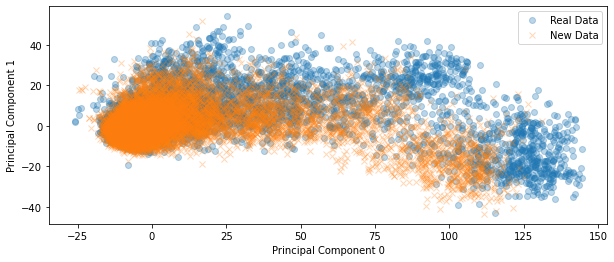

In [4]:
# concatenate and PCA takes around 30s. 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

tY = train_targets[ train_features['cp_type'] == 'trt_cp']
tX = train_features[train_features['cp_type'] == 'trt_cp']
tX = torch.tensor(tX.values[:, 4:].astype(np.float16)) 
tY = torch.tensor(tY.values[:, 1:].astype(np.float16))

# include labels in PCA, we want to find differences in train (X, Y) and augmented (X, Y)
X = np.concatenate((np.concatenate((tX, tY), 1), np.concatenate((X_add, Y_add), 1)), 0)
r = PCA().fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
n = train_features.shape[0]

ax.plot(r[:n,0], r[:n,1], 'o', alpha=0.3, label="Real Data")
ax.plot(r[n:,0], r[n:,1], 'x', alpha=0.3, label="New Data")
ax.set_ylabel("Principal Component 1")
ax.set_xlabel("Principal Component 0")
ax.legend()

print("\t\tX_new.shape=%s\tY_new.shape=%s"%(str(X_add.numpy().shape), str(Y_add.numpy().shape)))
plt.show()


# (Potentially) Improve With Adversarial Validation. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s finished


Logitic Regression Accuracy:  0.882047613248904
X.shape=(3109, 872)	Y.shape=torch.Size([3109, 206])


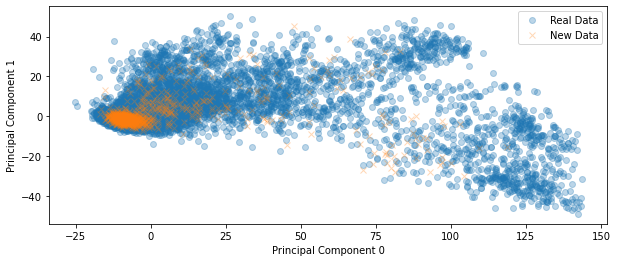

In [5]:
# Train logistic regression classifier to tell real/generated data apart.  
# Use classifier to discared points that doesn't look real. 
from sklearn.linear_model import LogisticRegression

# Construct dataset with real/generated data. 
X_disc = np.concatenate((tX, X_add), 0)
n = tX.shape[0]
Y_disc = np.ones(X_disc.shape[0], )
Y_disc[n:] = 0

clf = LogisticRegression(verbose=1, max_iter=500).fit(X_disc, Y_disc)
print("Logitic Regression Accuracy: ", clf.score(X_disc, Y_disc))

preds_fake = clf.predict_proba(X_disc[n:])
preds_real = clf.predict_proba(X_disc[:n])

# Keep points classifier predict more than p% real. 
n = tX.shape[0]
p = 0.5
reduced_X = X_disc[n:][preds_fake[:, 1] > p] 
reduced_Y = Y_add[preds_fake[:, 1] > p]

# Redo PCA
r = PCA().fit_transform(np.concatenate((np.concatenate((tX, tY), 1), np.concatenate((reduced_X, reduced_Y), 1)), 0))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
n = train_features.shape[0]

ax.plot(r[:n,0], r[:n,1], 'o', alpha=0.3, label="Real Data")
ax.plot(r[n:,0], r[n:,1], 'x', alpha=0.3, label="New Data")
ax.set_ylabel("Principal Component 1")
ax.set_xlabel("Principal Component 0")
ax.legend()

print("X.shape=%s\tY.shape=%s"%(str(reduced_X.shape), str(reduced_Y.shape)))

plt.show()

In [6]:
# **DISCLAIMER** 
# The above trick discards points in a way that does not preserve the label distribution. 
# This could be fixed by
# - use different probability limits for different labels (above uses 50% for all labels)
# - alternatively using rejection sampling when generating the data based on the logistic regression classifier. 
real_label_dist = np.unique(np.sum(train_targets.values[:, 1:], axis=-1), return_counts=True)[1]
gen_label_dist  = np.unique(reduced_Y[:, -206:].sum(-1), return_counts=True)[1]

print(real_label_dist[:4] / np.sum(real_label_dist[:4]))
print(gen_label_dist / np.sum(gen_label_dist))

[0.39456613 0.52788543 0.06478517 0.01276327]
[0.22161467 0.37697009 0.33451271 0.06690254]


-- probability cut off 0.100000 ---
X.shape=(15884, 872)	Y.shape=torch.Size([15884, 206])


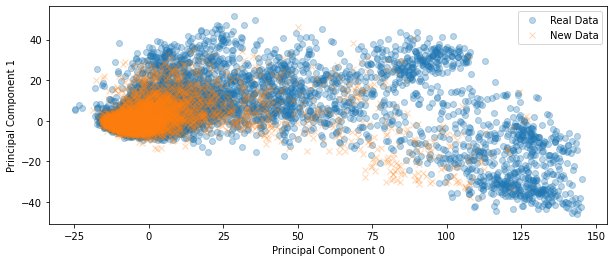

-- probability cut off 0.200000 ---
X.shape=(9618, 872)	Y.shape=torch.Size([9618, 206])


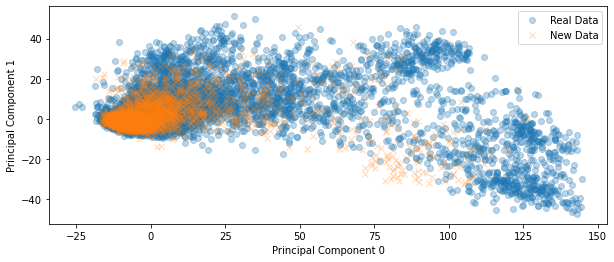

-- probability cut off 0.400000 ---
X.shape=(4413, 872)	Y.shape=torch.Size([4413, 206])


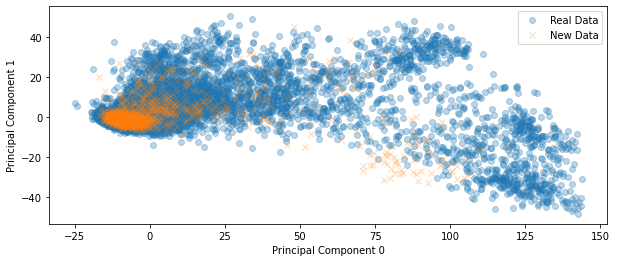

-- probability cut off 0.600000 ---
X.shape=(2155, 872)	Y.shape=torch.Size([2155, 206])


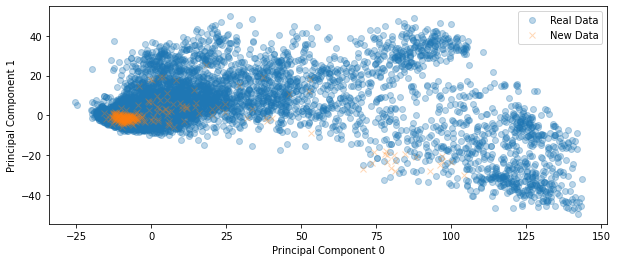

In [7]:
# recompute above PCA plot but for different cut-off probabilities. 
for p in [0.1, 0.2, 0.4, 0.6]: # Keep points classifier predict more than 50% real.
    n = tX.shape[0]
    reduced_X = X_disc[n:][preds_fake[:, 1] > p] 
    reduced_Y = Y_add[preds_fake[:, 1] > p]
    
    # Redo PCA
    r = PCA().fit_transform(np.concatenate((np.concatenate((tX, tY), 1), np.concatenate((reduced_X, reduced_Y), 1)), 0))

    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    n = train_features.shape[0]

    ax.plot(r[:n,0], r[:n,1], 'o', alpha=0.3, label="Real Data")
    ax.plot(r[n:,0], r[n:,1], 'x', alpha=0.3, label="New Data")
    ax.set_ylabel("Principal Component 1")
    ax.set_xlabel("Principal Component 0")
    ax.legend()

    print("-- probability cut off %-2f ---"%p)
    print("X.shape=%s\tY.shape=%s"%(str(reduced_X.shape), str(reduced_Y.shape)))
    plt.show()

# Ideas for improvement. 

- Train feature extract like deep autoencoder, use encodings to find distinct gene expression to be used in data generation.   
